## 4.3五花八门的Python分析包
### 4.3.1离散余弦变换

离散余弦变换（Discrete Cosine Transform，DCT）， 是数字图像处理过程中广泛采用的一种操作，用于将空域的图像转换为频域表示，从而能够更有效地进行压缩、滤波和特征提取等处理。它在许多应用领域中发挥着重要的作用，尤其在图像和视频压缩中，DCT变换常被用作预处理步骤。

著名的JEPG图像压缩算法就使用了DCT。

注：需要thinkdsp.py,thinkplot.py这两个文件在同一目录。

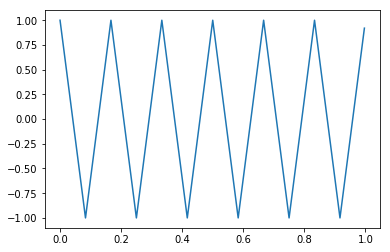

<Figure size 576x432 with 0 Axes>

In [2]:
import thinkdsp
import thinkplot

signal = thinkdsp.TriangleSignal(freq=6) #生成一个三角波
wave = signal.make_wave(duration=1.0, framerate=300)
wave.plot()
thinkplot.show()
##执行2次。

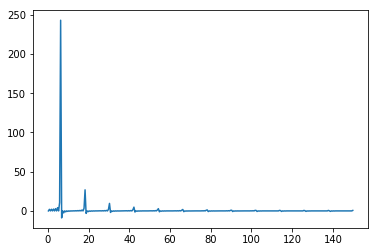

<Figure size 576x432 with 0 Axes>

In [3]:
dct = wave.make_dct()
dct.plot()
thinkplot.show()

### 4.3.2 时频分析

#### 1 小波变换

安装包
pip install PyWavelets

短时傅里叶变换由于窗口大小固定，所以具有一定的局限性，小波变换将短时傅里叶变换的无限长三角函数基换成了有限长的会衰减的小波基，由此小波变换作为一种新的变换分析方法，它继承并发展了短时傅里叶变换的思想，同时使用一个可以随频率改变大小的特殊窗口。

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pywt

# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

sampling_rate = 1024
t = np.arange(0, 1.0, 1.0 / sampling_rate)#起点为0；终点为1.0；步长为1.0 / 1024
f1 = 200  #三种频率
f2 = 300
f3 = 350
data = np.piecewise(t, [t < 1, t < 0.7, t < 0.3],
                    [lambda t: np.sin(2 * np.pi * f1 * t),#t<1时执行此句
                     lambda t: np.sin(2 * np.pi * f2 * t),#t<0.7时执行此句
                     lambda t: np.sin(2 * np.pi * f3 * t)])#t<0.3时执行此句
wavename = 'cgau8'
totalscal = 256
fc = pywt.central_frequency(wavename)
cparam = 2 * fc * totalscal
scales = cparam / np.arange(totalscal, 1, -1)
[cwtmatr, frequencies] = pywt.cwt(data, scales, wavename, 1.0 / sampling_rate)
#pywt.cwt连续小波变换
#data: 处理的信号
#scales:要使用的小波尺度
#wavename:用于指定使用的小波类型，例如‘haar', 'db1'至'db20'等
    
plt.figure(figsize=(8, 4))   #显示大小
plt.subplot(211)
plt.plot(t, data)
plt.xlabel(u"时间(秒)", fontsize=13)
plt.title(u"300Hz和200Hz和100Hz的分段波形和时频谱", fontsize=15)
plt.subplot(212)
plt.contourf(t, frequencies, abs(cwtmatr))
plt.ylabel(u"频率(Hz)", fontsize=13)
plt.xlabel(u"时间(秒)", fontsize=13)
plt.subplots_adjust(hspace=0.4)
plt.show()


### 经验模态分解

需安装包
pip install EMD-signal

In [ ]:
from PyEMD import EMD, Visualisation
import numpy as np

# 构建信号
t = np.arange(0, 1, 0.01)
S = 2 * np.sin(2 * np.pi * 15 * t) + 4 * np.sin(2 * np.pi * 10 * t) * np.sin(2 * np.pi * t * 0.1) + np.sin(
    2 * np.pi * 5 * t)
# 提取imfs和剩余信号res
emd = EMD(extrema_detection='parabol')
emd.emd(S)
imfs, res = emd.get_imfs_and_residue()
# 绘制 IMF
vis = Visualisation()
vis.plot_imfs(imfs=imfs, residue=res, t=t, include_residue=True)
# 绘制并显示所有提供的IMF的瞬时频率
vis.plot_instant_freq(t, imfs=imfs)
vis.show()


讲到这,后面内容不讲

### 4.3.3 动力学分析
需安装包 pip install pydy

导入用到的包

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sm
import sympy.physics.mechanics as me
from pydy.system import System

声明各个符号，杆的质量mA、平板的质量mB、沿杆方向到板中心的长度L_B、板的宽度W、板的高度H、重力加速度G。

In [ ]:
mA, mB, lB, w, h, g = sm.symbols('m_A, m_B, L_B, w, h, g')

定义杆和板的时变广义坐标和广义速度。theta是杆相对于天花板的角度，phi是板相对于杆的角度，omega是杆相对于天花板的角速度，alpha是相对于杆的角速度。之后定义运动学微分方程。dynamicsymbols方法表示动态的标识符，diff()是数据的差分。

In [ ]:
theta, phi = me.dynamicsymbols('theta, phi')
omega, alpha = me.dynamicsymbols('omega, alpha')
kin_diff = (omega - theta.diff(), alpha - phi.diff())


创建参考系，并设置方向。N代表固定物，A代表杆，B代表平板。

In [ ]:
N = me.ReferenceFrame('N')
A = me.ReferenceFrame('A')
B = me.ReferenceFrame('B')
A.orient(N, 'Axis', (theta, N.y))
B.orient(A, 'Axis', (phi, A.z))

定义杆旋转的固定点、杆的质心、板的质心。杆和板的点可以相对于杆旋转的固定点来定义。

In [ ]:
No = me.Point('No')
Ao = me.Point('Ao')
Bo = me.Point('Bo')
lA = (lB - h / 2) / 2
Ao.set_pos(No, lA * A.z)
Bo.set_pos(No, lB * A.z)


定义杆和板的角速度和线速度。

In [ ]:
A.set_ang_vel(N, omega * N.y)
B.set_ang_vel(A, alpha * A.z)
No.set_vel(N, 0)
Ao.v2pt_theory(No, N, A)
Bo.v2pt_theory(No, N, A)


根据杆的长度和质量获得其相对于参照系的惯性张量，根据板的宽度和高度获得板相对于参考系的惯性张量。

In [ ]:
IAxx = sm.S(1) / 12 * mA * (2 * lA)**2
IAyy = IAxx
IAzz = 0
IA = (me.inertia(A, IAxx, IAyy, IAzz), Ao)
IA[0].to_matrix(A)

IBxx = sm.S(1)/12 * mB * h**2
IByy = sm.S(1)/12 * mB * (w**2 + h**2)
IBzz = sm.S(1)/12 * mB * w**2
IB = (me.inertia(B, IBxx, IByy, IBzz), Bo)
IB[0].to_matrix(B)


使用前面获得的信息定义杆和板。

In [ ]:
rod = me.RigidBody('rod', Ao, A, mA, IA)
plate = me.RigidBody('plate', Bo, B, mB, IB)



定义载荷，载荷为作用于每个物体质心的力。

In [ ]:
rod_gravity = (Ao, mA * g * N.z)
plate_gravity = (Bo, mB * g * N.z)


使用广义的角速度、线速度、运动学微分方程和惯性参照系来初始化系统的运动方程，然后将负荷和实体传入进去，生成运动方程将其化为三角函数的形式。kane.kanes_equations()方法是导出系统。Trigsimp()函数表示换为三角函数


In [ ]:
kane = me.KanesMethod(N, q_ind=(theta, phi), u_ind=(omega, alpha), kd_eqs=kin_diff)
bodies = (rod, plate)
loads = (rod_gravity, plate_gravity)
fr, frstar = kane.kanes_equations(loads, bodies)
sm.trigsimp(fr)
sm.trigsimp(frstar)


使用数值的来模拟运动方程。

In [ ]:
sys = System(kane)
sys.constants = {lB: 0.2, h: 0.1, w: 0.2, mA: 0.01, mB: 0.1, g: 9.81} 
sys.initial_conditions = {theta: np.deg2rad(45), phi: np.deg2rad(0.5), omega: 0, alpha: 0}
sys.times = np.linspace(0, 100, 500)


画出在不同初始条件下的结果，deg2rad()表示将角度转换为弧度制。由图4.3.5可以看到两个平板初始角度仅仅相差了0.2，在运动一段时间后表现出了非常大的差异，验证了该钟摆系统存在混沌现象。

In [ ]:
def plot():
    plt.figure()
    plt.plot(sys.times, np.rad2deg(x[:, :2]))
    plt.legend([sm.latex(s, mode='inline') for s in sys.coordinates])
    plt.show()

sys.initial_conditions[theta] = np.deg2rad(200)
sys.initial_conditions[phi] = np.deg2rad(0.5)
x = sys.integrate()
plot()

sys.initial_conditions[theta] = np.deg2rad(200)
sys.initial_conditions[phi] = np.deg2rad(0.7)
x = sys.integrate()
plot()
